In [ ]:
# 23-12-14 : NSGA iii v2_1 running succesylly
# 23-12-18 : get optimal sols using tools.selBest(res, n), revenrse transformation, setting up mcdm approach based on topsis
# 23-12-27 : set up multi objective optimisation via weightage topsis
# 24-01-01 : nsga iii set up with objectives as reference points
# 24-01-03 : hypervolume computation
# 25-01-08 : setting up expeirments with parameter scaled crossover

In [ ]:
import time, array, random, copy, math
from itertools import chain
from operator import attrgetter, itemgetter
from sympy import symbols, solve

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
from matplotlib.path import Path
import matplotlib.patches as patches

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.1 MB/s eta 0:00:00


In [ ]:
from deap import algorithms, base, benchmarks, tools, creator
import numpy as np
import copy,random

# modules

In [ ]:
class ReferencePoint(list):
    '''A reference point exists in objective space an has a set of individuals
    associated to it.'''
    def __init__(self, *args):
        list.__init__(self, *args)
        self.associations_count = 0
        self.associations = []

In [ ]:
def generate_reference_points(num_objs, num_divisions_per_obj):
    '''Generates reference points for NSGA-III selection. This code is based on
    `jMetal NSGA-III implementation <https://github.com/jMetal/jMetal>`_.
    '''
    def gen_refs_recursive(work_point, num_objs, left, total, depth):
        if depth == num_objs - 1:
            work_point[depth] = left/total
            ref = ReferencePoint(copy.deepcopy(work_point))
            return [ref]
        else:
            res = []
            for i in range(left):
                work_point[depth] = i/total
                res = res + gen_refs_recursive(work_point, num_objs, left-i, total, depth+1)
            return res
    return gen_refs_recursive([0]*num_objs, num_objs, num_objs*num_divisions_per_obj,
                              num_objs*num_divisions_per_obj, 0)

In [ ]:
def find_ideal_point(individuals):
    'Finds the ideal point from a set individuals.'
    current_ideal = [np.infty] * len(individuals[0].fitness.values)
    for ind in individuals:
        # Use wvalues to accomodate for maximization and minimization problems.
        current_ideal = np.minimum(current_ideal,
                                  np.multiply(ind.fitness.wvalues, -1))
    return current_ideal

In [ ]:
def find_extreme_points(individuals):
    'Finds the individuals with extreme values for each objective function.'
    return [sorted(individuals, key=lambda ind:ind.fitness.wvalues[o] * -1)[-1]
            for o in range(len(individuals[0].fitness.values))]

In [ ]:
def construct_hyperplane(individuals, extreme_points):
    'Calculates the axis intersects for a set of individuals and its extremes.'
    def has_duplicate_individuals(individuals):
        for i in range(len(individuals)):
            for j in range(i+1, len(individuals)):
                if individuals[i].fitness.values == individuals[j].fitness.values:
                    return True
        return False

    num_objs = len(individuals[0].fitness.values)

    if has_duplicate_individuals(extreme_points):
        intercepts = [extreme_points[m].fitness.values[m] for m in range(num_objs)]
    else:
        b = np.ones(num_objs)
        A = [point.fitness.values for point in extreme_points]
        x = np.linalg.solve(A,b)
        intercepts = 1/x
    return intercepts

In [ ]:
def normalize_objective(individual, m, intercepts, ideal_point, epsilon=1e-20):
    'Normalizes an objective.'
    # Numeric trick present in JMetal implementation.
    if np.abs(intercepts[m]-ideal_point[m] > epsilon):
        return individual.fitness.values[m] / (intercepts[m]-ideal_point[m])
    else:
        return individual.fitness.values[m] / epsilon

In [ ]:
def normalize_objectives(individuals, intercepts, ideal_point):
    '''Normalizes individuals using the hyperplane defined by the intercepts as
    reference. Corresponds to Algorithm 2 of Deb & Jain (2014).'''
    num_objs = len(individuals[0].fitness.values)

    for ind in individuals:
        ind.fitness.normalized_values = list([normalize_objective(ind, m,
                                                                  intercepts, ideal_point)
                                                                  for m in range(num_objs)])
    return individuals

In [ ]:
def perpendicular_distance(direction, point):
    k = np.dot(direction, point) / np.sum(np.power(direction, 2))
    d = np.sum(np.power(np.subtract(np.multiply(direction, [k] * len(direction)), point) , 2))
    return np.sqrt(d)

In [ ]:
def associate(individuals, reference_points):
    '''Associates individuals to reference points and calculates niche number.
    Corresponds to Algorithm 3 of Deb & Jain (2014).'''
    pareto_fronts = tools.sortLogNondominated(individuals, len(individuals))
    num_objs = len(individuals[0].fitness.values)

    for ind in individuals:
        rp_dists = [(rp, perpendicular_distance(ind.fitness.normalized_values, rp))
                    for rp in reference_points]
        best_rp, best_dist = sorted(rp_dists, key=lambda rpd:rpd[1])[0]
        ind.reference_point = best_rp
        ind.ref_point_distance = best_dist
        best_rp.associations_count +=1 # update de niche number
        best_rp.associations += [ind]
    print("pareto front in associate", '\n', pareto_fronts)
    return pareto_fronts

In [ ]:
def create_ref_points(eqns):
    reference_points = []
    eqns2 = np.array(eqns).T
    var = ['x'] * (len(eqns2[0]) - 1)
    for coeff in eqns2:
      for i in range(len(coeff)-1):
        solution = [0] * (len(coeff)- 1)
        x = symbols(var[i])
        expr = coeff[i] * x + coeff[-1:][0]
        sol = solve(expr)
        solution[i] = float(sol[0]) if len(sol) > 0 else 0
        solution.append(coeff[-1:][0])
        reference_points.append(ReferencePoint(solution))
    return reference_points

In [ ]:
def niching_select(individuals, k, eqns):
      '''Secondary niched selection based on reference points. Corresponds to
      steps 13-17 of Algorithm 1 and to Algorithm 4.'''
      if len(individuals) == k:
          return individuals

      #individuals = copy.deepcopy(individuals)

      ideal_point = find_ideal_point(individuals)
      extremes = find_extreme_points(individuals)
      intercepts = construct_hyperplane(individuals, extremes)
      normalize_objectives(individuals, intercepts, ideal_point)

      reference_points = generate_reference_points(len(individuals[0].fitness.values), num_divisions_per_obj)
      #reference_points = create_ref_points(eqns)

      pareto_fronts = associate(individuals, reference_points)

      res = []
      while len(res) < k:
          min_assoc_rp = min(reference_points, key=lambda rp: rp.associations_count)
          min_assoc_rps = [rp for rp in reference_points if rp.associations_count == min_assoc_rp.associations_count]
          chosen_rp = min_assoc_rps[random.randint(0, len(min_assoc_rps)-1)]

          #print('Rps',min_assoc_rp.associations_count, chosen_rp.associations_count, len(min_assoc_rps))

          associated_inds = chosen_rp.associations

          if chosen_rp.associations:
              if chosen_rp.associations_count == 0:
                  sel = min(chosen_rp.associations, key=lambda ind: ind.ref_point_distance, default = "EMPTY")
              else:
                  sel = chosen_rp.associations[random.randint(0, len(chosen_rp.associations)-1)]
              res += [sel]
              chosen_rp.associations.remove(sel)
              chosen_rp.associations_count += 1
              individuals.remove(sel)
          else:
              reference_points.remove(chosen_rp)
      #for i in pareto_fronts[0]:
        #print(list(i),",")
      return res
    except:
      return individuals

# environment dev

In [ ]:
number_of_variables = 3 # number of variables
number_of_obj = 4 # number of objectives
num_divisions_per_obj = 4 # no of divisions per object
num_objs = number_of_obj
P = 20 #  no of divisions of the hyperplane
H = 100 # factorial(number_of_obj + P - 1) / (factorial(P) * factorial(number_of_obj - 1))
number_of_gen = 200 # max no of generations
bounds_low, bounds_up = 0, 1
MU = int(H + (number_of_variables - H % number_of_variables)) # no of candidates in population
max_pop = 200
max_gen = 10

global eqns
eqns = [[5,2,3,4],
        [-5,6,-1,4],
        [20,9,-10,3],
        [5, -10, 1, 0]]
global paretofronts

In [ ]:
creator.create("FitnessMin3", base.Fitness, weights=(-1.0,) * number_of_obj)
creator.create("Individual3", array.array, typecode='d',
               fitness=creator.FitnessMin3)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin3' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual3' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
def sel_nsga_iii(individuals, k):
      '''Implements NSGA-III selection as described in
      Deb, K., & Jain, H. (2014). An Evolutionary Many-Objective Optimization
      Algorithm Using Reference-Point-Based Nondominated Sorting Approach,
      Part I: Solving Problems With BoxConstraints. IEEE Transactions on
      Evolutionary Computation, 18(4), 577–601. doi:10.1109/TEVC.2013.2281535.
      '''

      assert len(individuals) >= k

      if len(individuals)==k:
          return individuals

      # Algorithm 1 steps 4--8
      fronts = tools.sortLogNondominated(individuals, len(individuals))
      #print("front in main", '\n', fronts)
      paretofronts = fronts



      limit = 0
      res =[]
      for f, front in enumerate(fronts):
          res += front
          if len(res) > k:
              limit = f
              break
      # Algorithm 1 steps
      selection = []
      if limit > 0:
          for f in range(limit):
              selection += fronts[f]

      # complete selected inividuals using the referece point based approach
      set_of_optimal_candidates = niching_select(fronts[limit], k - len(selection), eqns)
      selection+= set_of_optimal_candidates[0]
      pareto = set_of_optimal_candidates[1]
      pareto_front = selection
      return selection

__all__ = ["sel_nsga_iii"]

In [ ]:
def prepare_toolbox(problem_instance, selection_func, number_of_variables, bounds_low, bounds_up, eqns):

    def uniform(low, up, size=None):
        try:
            return [random.uniform(a, b) for a, b in zip(low, up)]
        except TypeError:
            return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

    def functest(a,b):
      print("functest", a+b, a+2*b)
      return 0

    toolbox = base.Toolbox()

    toolbox.register('evaluate', problem_instance)
    toolbox.register('select', selection_func)

    toolbox.register("attr_float", uniform, bounds_low, bounds_up, number_of_variables)

    toolbox.register("individual", tools.initIterate, creator.Individual3, toolbox.attr_float)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)


    toolbox.register("mate", tools.cxSimulatedBinaryBounded,
                     low=bounds_low, up=bounds_up, eta=20.0)

    toolbox.register("mutate", tools.mutPolynomialBounded,
                     low=bounds_low, up=bounds_up, eta=20.0,
                     indpb=1.0/number_of_variables)

    toolbox.register("cross", functest, bounds_low, bounds_up)

    toolbox.register('select', selection_func)


    toolbox.pop_size = max_pop   # max population size allowed
    toolbox.max_gen = max_gen    # max number of iteration
    toolbox.mut_prob = 1/number_of_variables
    toolbox.cross_prob = 0.3

    return toolbox

In [ ]:
toolbox = prepare_toolbox(lambda ind: benchmarks.dtlz2(ind, number_of_obj),
                          sel_nsga_iii, number_of_variables,
                          bounds_low, bounds_up, eqns)

In [ ]:
# creating a population and evaluation

In [ ]:
def nsga_iii(toolbox, stats = None, verbose=False): # stats=None
      population = toolbox.population(n=toolbox.pop_size)
      return algorithms.eaMuPlusLambda(population, toolbox,
                                mu=toolbox.pop_size,
                                lambda_=toolbox.pop_size,
                                cxpb=toolbox.cross_prob,
                                mutpb=toolbox.mut_prob,
                                ngen=toolbox.max_gen,
                                stats=stats, verbose=verbose)

# implement

In [ ]:
%time res, logbook = nsga_iii(toolbox)

pareto front in associate 
 [[Individual3('d', [0.9544434929891237, 0.7898813816433427, 0.9922523554926007]), Individual3('d', [0.9744613083745659, 0.9727732579210793, 0.5754658203121638]), Individual3('d', [0.9744613083745659, 0.9727732579210793, 0.5754658203121638]), Individual3('d', [0.9962837444941114, 0.6007731486218325, 0.7353974111011753]), Individual3('d', [0.9138036478422674, 0.9878297832288379, 0.5667332988503141]), Individual3('d', [0.9907946139592524, 0.9158733095207153, 0.2935627765046541]), Individual3('d', [0.9907946139592524, 0.9158733095207153, 0.2935627765046541]), Individual3('d', [0.9907946139592524, 0.9158733095207153, 0.2935627765046541]), Individual3('d', [0.9907946139592524, 0.9158733095207153, 0.2935627765046541]), Individual3('d', [0.9907946139592524, 0.9158733095207153, 0.2935627765046541]), Individual3('d', [0.9758874223273198, 0.7704732942235566, 0.8872323807610593]), Individual3('d', [0.9671280376056303, 0.8008465053241994, 0.8872323807610593]), Individual

TypeError: object of type 'float' has no len()

## plot

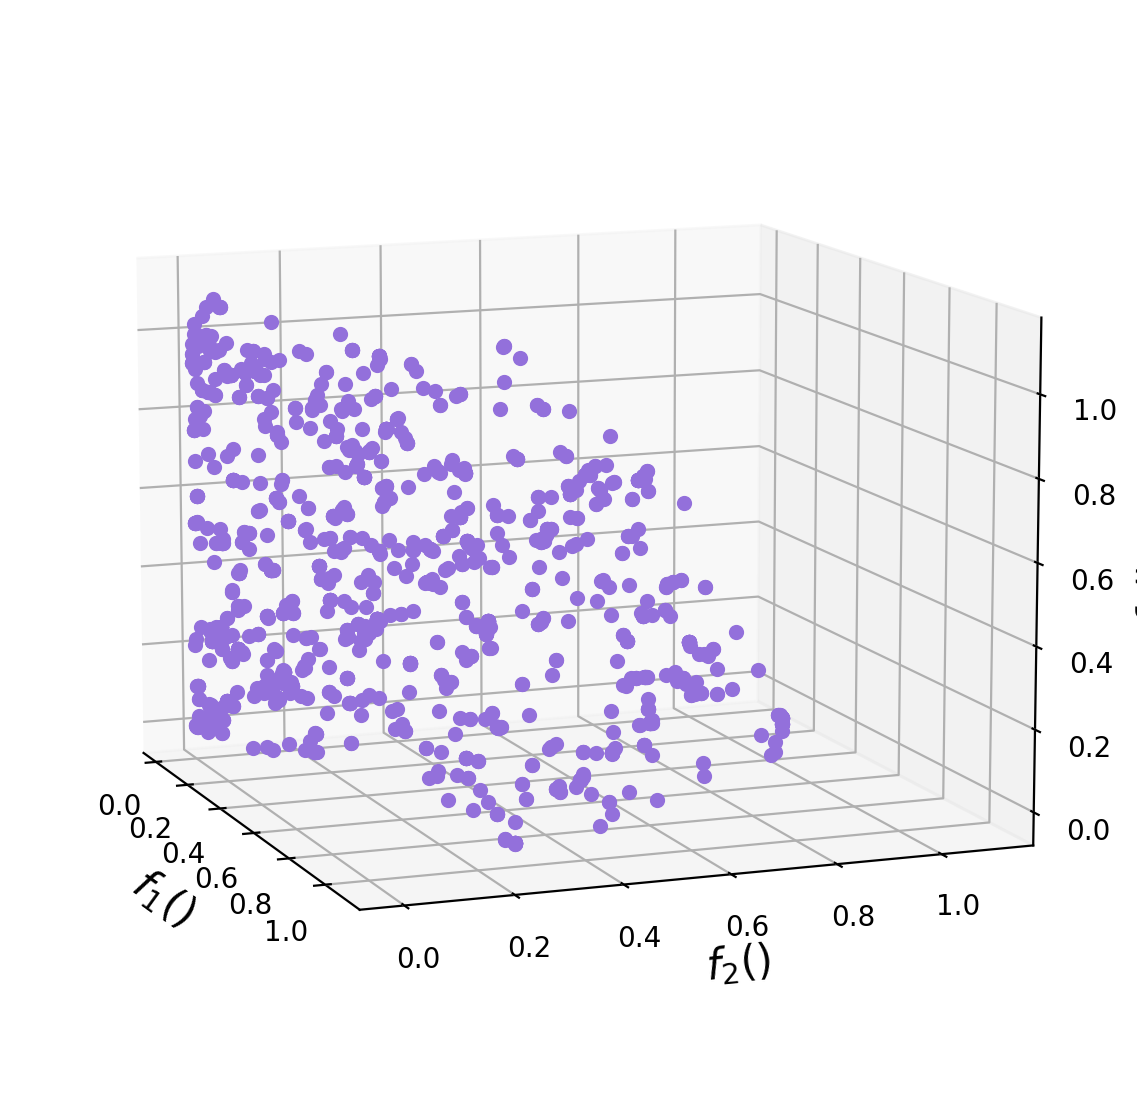

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for ind in res:
    ax.scatter(ind.fitness.values[0],
               ind.fitness.values[1],
               ind.fitness.values[2], marker='o', color='mediumpurple')

ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=11, azim=-21)
plt.autoscale(tight=True)

In [ ]:
optimal_values = tools.selBest(res, 50)
optimal_values

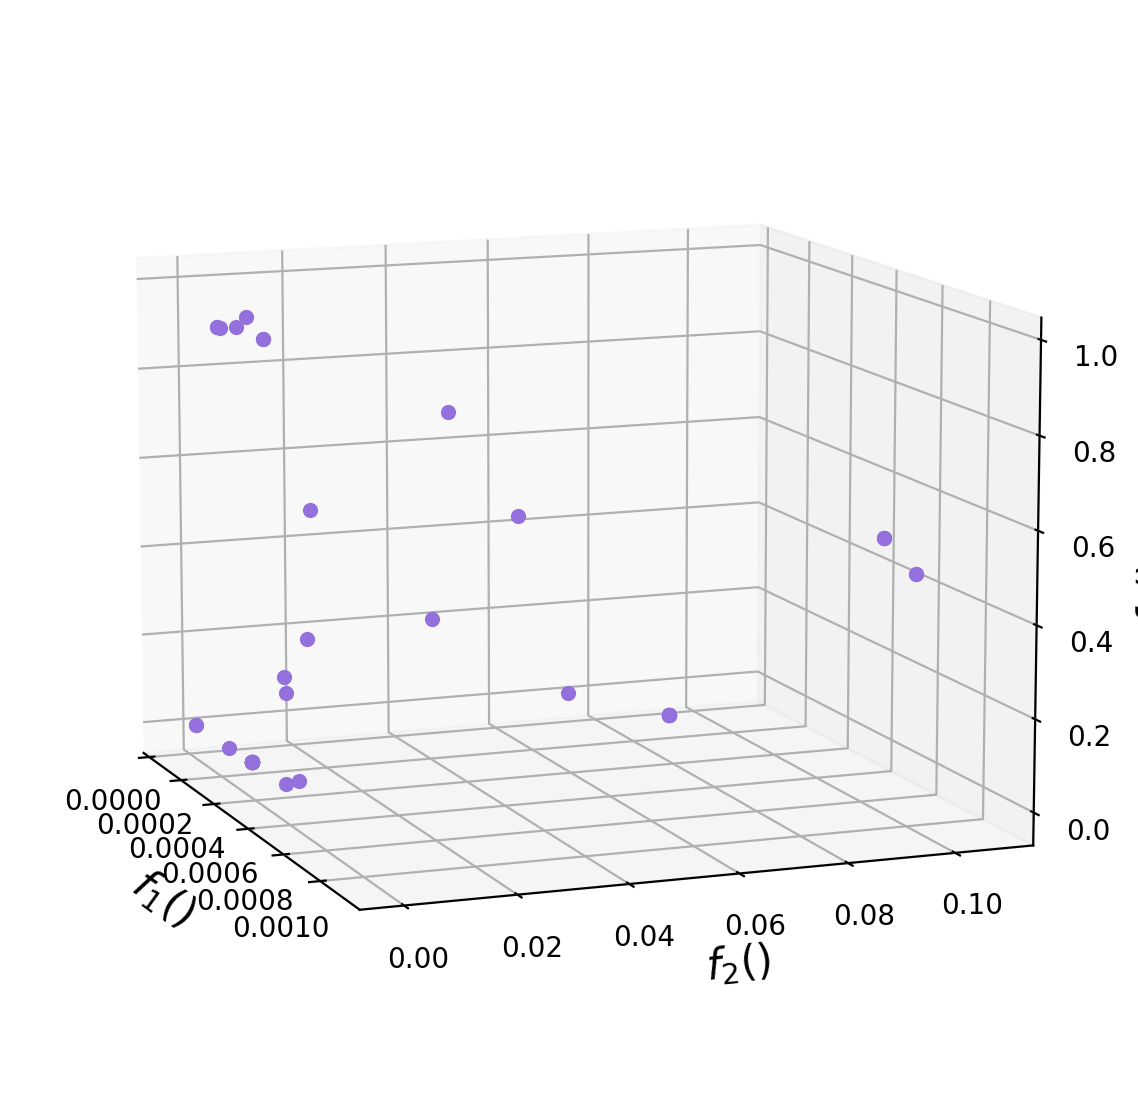

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for ind in optimal_values:
    ax.scatter(ind.fitness.values[0],
               ind.fitness.values[1],
               ind.fitness.values[2], marker='o', color='mediumpurple')

ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=11, azim=-21)
plt.autoscale(tight=True)

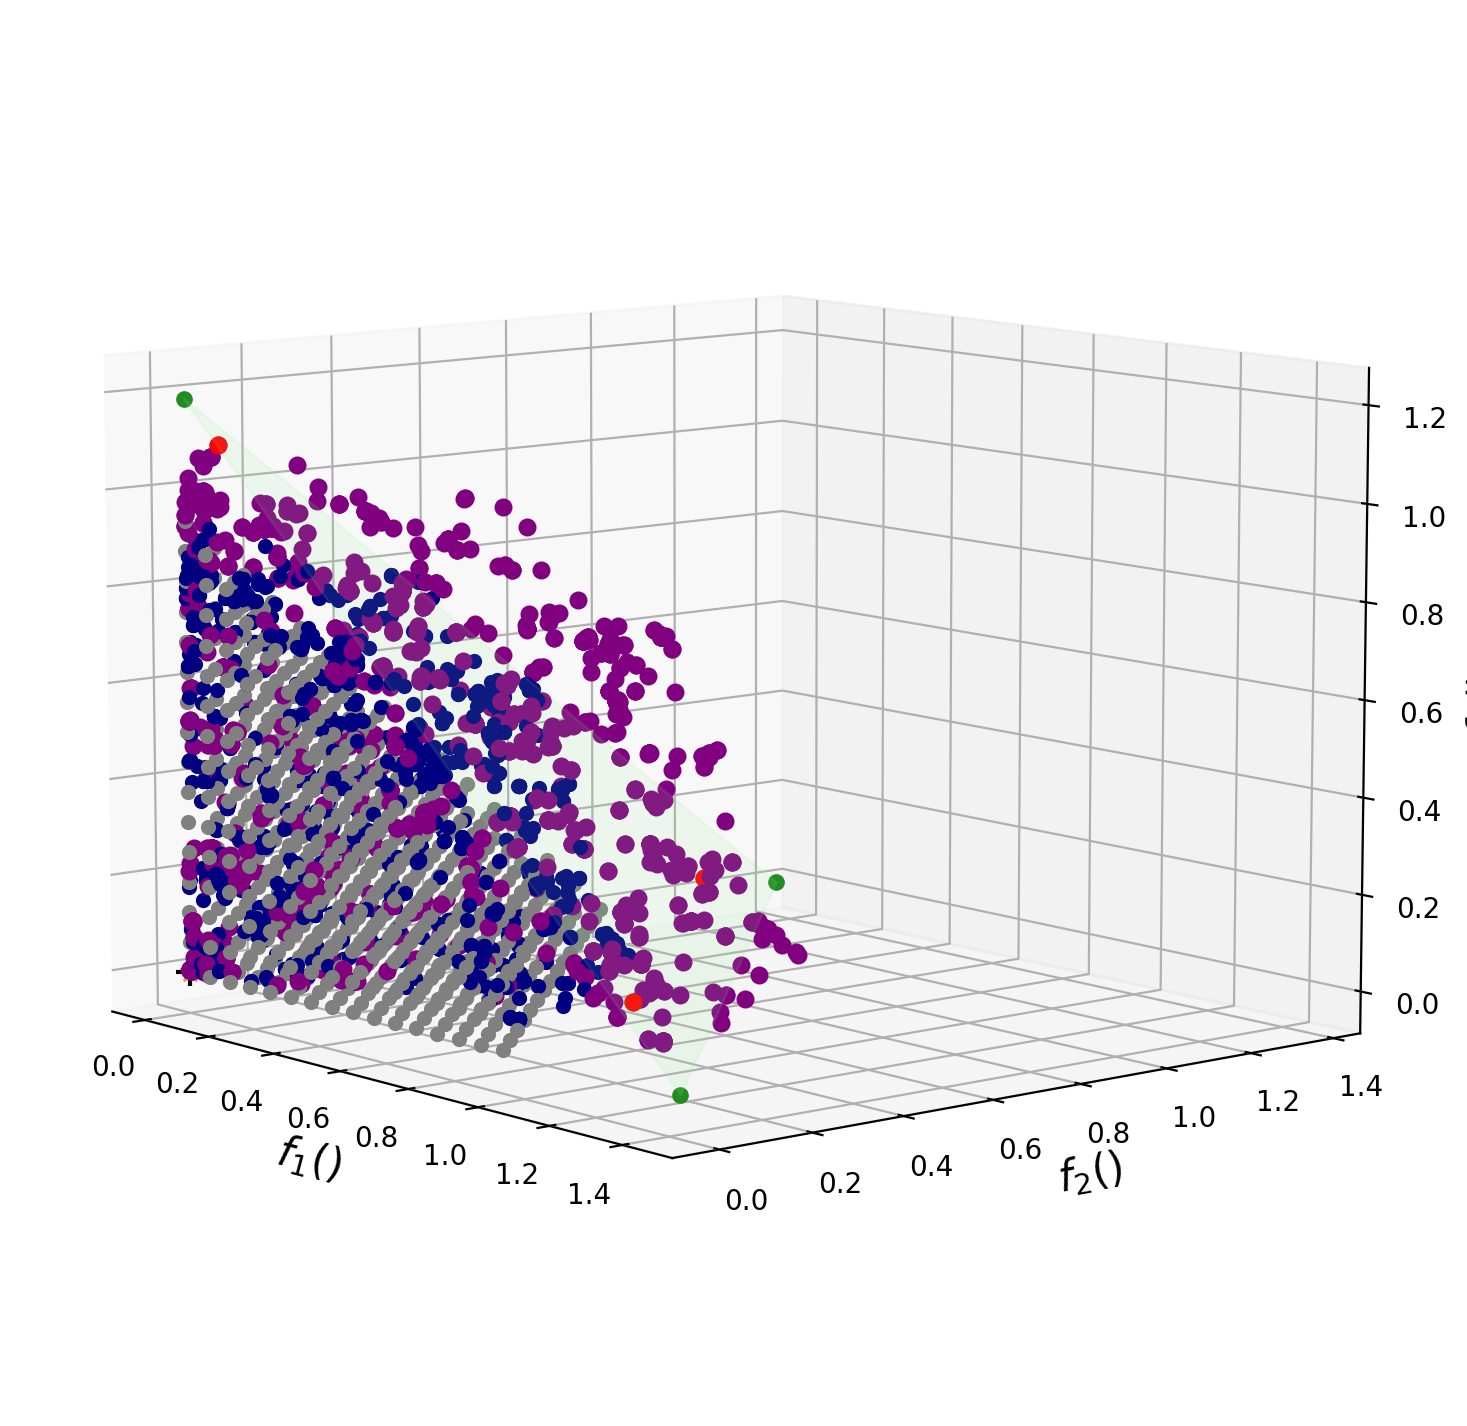

In [ ]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin (black + sign)
ax.scatter(0,0,0, c='k', marker='+', s=100)

# the population (purple)
for ind in res:
    ax.scatter(ind.fitness.values[0],
               ind.fitness.values[1],
               ind.fitness.values[2],
               color='purple',
               s=30, marker='o')

# ideal point (red star)
ideal_point = find_ideal_point(res)
ax.scatter(ideal_point[0], ideal_point[1], ideal_point[2],
           s=50, marker='*', color='salmon')

# extreme points marked (red)
extremes = find_extreme_points(res)
for i,ex in enumerate(extremes):
    ax.scatter(ex.fitness.values[0],
               ex.fitness.values[1],
               ex.fitness.values[2], s=30, marker='o', color='r')

# intercepts (in green)
intercepts = construct_hyperplane(res, extremes)
verts = [(intercepts[0], 0, 0), (0, intercepts[1], 0), (0, 0, intercepts[2])]

for vert in verts:
    ax.scatter(vert[0], vert[1], vert[2],  color='forestgreen', s=100, marker='.')

tri = a3.art3d.Poly3DCollection([verts])
tri.set_color('lightgreen')
tri.set_alpha(0.11)
tri.set_edgecolor('lightgreen')
ax.add_collection3d(tri)

# normalized objectives (navy)
normalize_objectives(res, intercepts, ideal_point)

for ind in res:
    ax.scatter(ind.fitness.normalized_values[0],
               ind.fitness.normalized_values[1],
               ind.fitness.normalized_values[2], color='navy', marker='o')

# reference points (gray)
rps = generate_reference_points(num_objs, num_divisions_per_obj)
for rp in rps:
    ax.scatter(rp[0], rp[1], rp[2], marker='o', color='gray')

# final figure details
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=9, azim=-40)
plt.autoscale(tight=True)

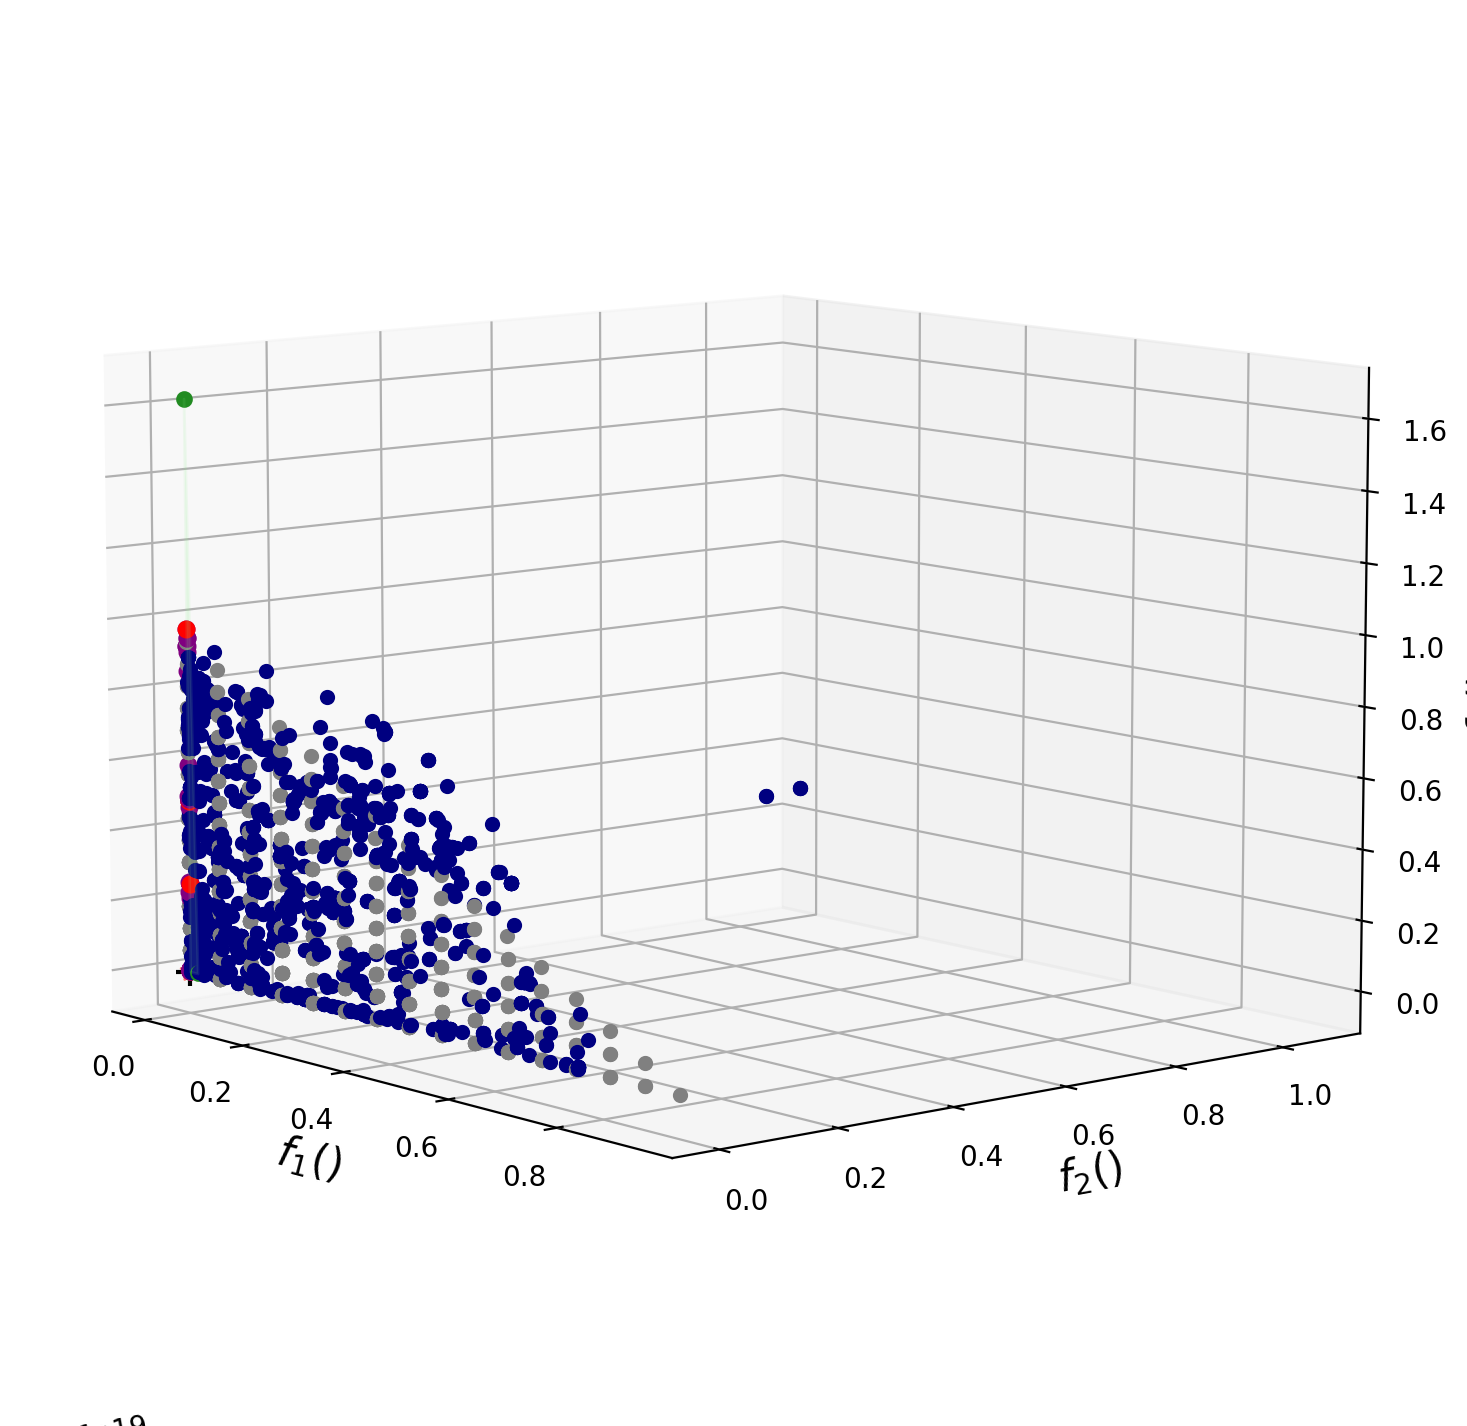

In [ ]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin (black + sign)
ax.scatter(0,0,0, c='k', marker='+', s=100)

# the population (purple)
for ind in optimal_values:
    ax.scatter(ind.fitness.values[0],
               ind.fitness.values[1],
               ind.fitness.values[2],
               color='purple',
               s=30, marker='o')

# ideal point (red star)
ideal_point = find_ideal_point(optimal_values)
ax.scatter(ideal_point[0], ideal_point[1], ideal_point[2],
           s=50, marker='*', color='salmon')

# extreme points marked (red)
extremes = find_extreme_points(optimal_values)
for i,ex in enumerate(extremes):
    ax.scatter(ex.fitness.values[0],
               ex.fitness.values[1],
               ex.fitness.values[2], s=30, marker='o', color='r')

# intercepts (in green)
intercepts = construct_hyperplane(optimal_values, extremes)
verts = [(intercepts[0], 0, 0), (0, intercepts[1], 0), (0, 0, intercepts[2])]

for vert in verts:
    ax.scatter(vert[0], vert[1], vert[2],  color='forestgreen', s=100, marker='.')

tri = a3.art3d.Poly3DCollection([verts])
tri.set_color('lightgreen')
tri.set_alpha(0.11)
tri.set_edgecolor('lightgreen')
ax.add_collection3d(tri)

# normalized objectives (navy)
normalize_objectives(optimal_values, intercepts, ideal_point)

for ind in res:
    ax.scatter(ind.fitness.normalized_values[0],
               ind.fitness.normalized_values[1],
               ind.fitness.normalized_values[2], color='navy', marker='o')

# reference points (gray)
rps = generate_reference_points(num_objs, num_divisions_per_obj)
for rp in rps:
    ax.scatter(rp[0], rp[1], rp[2], marker='o', color='gray')

# final figure details
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=9, azim=-40)
plt.autoscale(tight=True)

In [ ]:
# reverse mapping

In [ ]:
# three variables :
# promotional price (100-200)
# Inventory purchase (0-10000)
# promotional budget (100000-500000)

In [ ]:
optimal_values[0]

Individual3('d', [0.9962894248203733, 0.9924080827025444, 0.6097551629172578, 0.22810066414211438])

In [ ]:
min_pp, max_pp = 100, 200
min_ip, max_ip = 0, 10000
min_pb, max_pb = 50000, 100000

In [ ]:
optimal_sols = []
for i in optimal_values:
  pp = i[0] * (max_pp-min_pp) + min_pp
  ip = i[1] * (max_ip-min_ip) + min_ip
  pb = i[3] * (max_pb-min_pb) + min_pb
  optimal_sols.append([pp,ip,pb])
optimal_sols

[[199.62894248203733, 9924.080827025444, 61405.03320710572],
 [199.62894248203733, 9924.080827025444, 61405.03320710572],
 [128.26411272053528, 9958.201600393675, 79610.40460473945],
 [133.23355869844892, 9996.639825284727, 61922.64121882192],
 [133.23355869844892, 9996.639825284727, 61922.64121882192],
 [133.23355869844892, 9996.639825284727, 61922.64121882192],
 [199.85069092211984, 9117.741287015953, 92134.41989246834],
 [183.6266961078057, 9694.17191841516, 69855.83498154725],
 [126.778465578038, 9994.045703706754, 61922.64121882192],
 [168.78751337793568, 9348.497198490446, 88341.44060590956],
 [199.76621093138186, 9117.741287015953, 92134.41989246834],
 [199.76621093138186, 9117.741287015953, 92134.41989246834],
 [199.76621093138186, 9117.741287015953, 92134.41989246834],
 [199.76621093138186, 9117.741287015953, 92134.41989246834],
 [199.76621093138186, 9117.741287015953, 92134.41989246834],
 [199.76621093138186, 9117.741287015953, 92134.41989246834],
 [199.76621093138186, 9117.7

In [ ]:
# 4 objectives
# revenue maximised : promotional price * (beginning inventory + inventory purchase) - promotional budget
# lift maximised : baseline sales * normal price - (beginning inventory + inventory purchase) * promotional price
# ending inventory minimised : (beginning inventory + inventory purchase) * cost price
# profit maximised : (beginning inventory + inventory purchase) * (promotional price - cost price)
# priority order: lift maximised, revenue maximised, ending inventory minimised, profit maximised

In [ ]:
cost_price = 100
normal_price = 200
begin_inv = 5000
base_sales = 5000

In [ ]:
objectives = []
for i in optimal_sols:
  obj1 = i[0] + (begin_inv+i[1]) - i[2]
  obj2 = (begin_inv+i[1]) * i[0] - base_sales * normal_price
  obj3 = (begin_inv +i[1]) * cost_price
  obj4 = (begin_inv + i[1]) * (i[0]- cost_price)
  objectives.append([obj1, obj2, obj3, obj4])
objectives = np.array(objectives)

In [ ]:
# user to be asked priority of objectives

In [ ]:
priority_order = [0] * number_of_obj
scale = [0] * number_of_obj
for i in range(number_of_obj-1):
  job = int(input("enter the objective of highest priority : "))
  p = str(input("enter max or min : "))
  priority_order[job-1] = i+1
  scale[job-1] = p
pos = priority_order.index(0)
priority_order[pos] = number_of_obj
scale[pos] = str(input("enter max or min for last objective : "))
print(priority_order, scale)

In [ ]:
new_objectives = np.array(objectives)
priority_order = [4,3,2,1]
scale = ['max', 'max', 'min', 'max']

In [ ]:
for i in range(number_of_obj):
  job = priority_order.index(min(priority_order))
  p = scale[job]
  if p == 'min':
    tsol1 = [i for i,val in enumerate(new_objectives[:,job]) if val==min(new_objectives[:,job])]
  else:
    tsol1 = [i for i,val in enumerate(new_objectives[:,job]) if val==max(new_objectives[:,job])]
  new_objectives2 = []
  for i in tsol1:
    new_objectives2.append(new_objectives[i])
  new_objectives = np.array(new_objectives2)
  priority_order[job] = np.inf
  print(new_objectives, priority_order)

[[ -46281.3234376  1979278.47301554 1492408.08270254 1486870.39031299]
 [ -46281.3234376  1979278.47301554 1492408.08270254 1486870.39031299]] [4, 3, 2, inf]
[[ -46281.3234376  1979278.47301554 1492408.08270254 1486870.39031299]
 [ -46281.3234376  1979278.47301554 1492408.08270254 1486870.39031299]] [4, 3, inf, inf]
[[ -46281.3234376  1979278.47301554 1492408.08270254 1486870.39031299]
 [ -46281.3234376  1979278.47301554 1492408.08270254 1486870.39031299]] [4, inf, inf, inf]
[[ -46281.3234376  1979278.47301554 1492408.08270254 1486870.39031299]
 [ -46281.3234376  1979278.47301554 1492408.08270254 1486870.39031299]] [inf, inf, inf, inf]


In [ ]:
print("optimised_objective: ", new_objectives)

optimised_objective:  [[ -46281.3234376  1979278.47301554 1492408.08270254 1486870.39031299]
 [ -46281.3234376  1979278.47301554 1492408.08270254 1486870.39031299]]


In [ ]:
optimised_solution = optimal_sols[np.where(objectives == new_objectives[0])[0][0]]

In [ ]:
print("optimised_scenario: ", optimised_solution)

optimised_scenario:  [199.62894248203733, 9924.080827025444, 61405.03320710572]


In [ ]:
objectives

# hypervolume

In [ ]:
!pip install pygmo
from pygmo import hypervolume

In [ ]:
pareto = [[0.9963349103034685, 0.982735791346051, 0.7483506157294074] ,
[0.9963349103034685, 0.982735791346051, 0.7483506157294074] ,
[0.5035287422296364, 0.9998412392604161, 0.650860456143271] ,
[0.9992555706617318, 0.037738868630153743, 0.9417956394602972] ,
[0.6395757245489109, 0.9997369755130198, 0.09465111768651158] ,
[0.9297987278858318, 0.995933870217296, 0.050155854033861136] ,
[0.9687523538462542, 0.9755403828634943, 0.1553231185727002] ,
[0.9866298474358477, 0.9064266933694383, 0.44109533009117996] ,
[0.48401891277282705, 0.9589790984615186, 0.9627173176438935] ,
[0.9934171467177958, 0.7971017355934663, 0.17705930042939766] ,
[0.9934171467177958, 0.7971017355934663, 0.17705930042939766] ,
[0.9896626393639686, 0.7216342001062189, 0.6817912137561554] ,
[0.9896626393639686, 0.7216342001062189, 0.6817912137561554] ,
[0.9896626393639686, 0.7216342001062189, 0.6809834427002139] ,
[0.48401891277282705, 0.9589790984615186, 0.9544315830534564] ,
[0.7189068598281653, 0.7941234448744309, 0.9832201612699438] ,
[0.30858304781508783, 0.5788635758561742, 0.9954250617536193] ,
[0.963612303960737, 0.5761745110417187, 0.9048525483401448] ,
[0.30858304781508783, 0.2846254375166761, 0.9954250617536193] ,
[0.6924881235198049, 0.9821308296200675, 0.6958523494983878] ,
[0.6924881235198049, 0.9821308296200675, 0.6958523494983878] ,
[0.30858304781508783, 0.19411798104249134, 0.9954250617536193] ,
[0.9107713255444556, 0.8161709805525041, 0.9000848410411906] ,
[0.5003858338476499, 0.9760396802943757, 0.8369903001886717] ,
[0.5003858338476499, 0.9760396802943757, 0.8369903001886717] ,
[0.9332678988908669, 0.9529100598649005, 0.0453021782757248] ,
[0.9044025659609604, 0.006656680684839045, 0.9653669470596657] ,
[0.9044025659609604, 0.0015985697782487929, 0.9653669470596657] ,
[0.5625721320394051, 0.9821308296200675, 0.6958523494983878] ,
[0.7189068598281653, 0.8471856136008548, 0.9483735195092782] ,
[0.7189068598281653, 0.8471856136008548, 0.9483735195092782] ,
[0.901135557770021, 0.006656680684839045, 0.9653669470596657] ,
[0.12906125535965252, 0.793225264190099, 0.9825963902047871] ,
[0.12906125535965252, 0.793225264190099, 0.9825963902047871] ,
[0.12906125535965252, 0.793225264190099, 0.9825963902047871] ,
[0.9816783494327417, 0.7971017355934663, 0.17705930042939766] ,
[0.19210938872155536, 0.751965581246492, 0.9825963902047871] ,
[0.543295799316221, 0.7204041594408089, 0.9737922572934632] ,
[0.543295799316221, 0.7204041594408089, 0.9737922572934632] ,
[0.8164550711671539, 0.608479118893685, 0.9544315830534564] ,
[0.6924881235198049, 0.9653225743109349, 0.6864269959439214] ,
[0.9083798492082275, 0.6407779232097799, 0.9000848410411906] ,
[0.9083798492082275, 0.6407779232097799, 0.9000848410411906] ,
[0.5123341170577238, 0.9346261168809592, 0.8880435995305629] ,
[0.7790472676978581, 0.9417391143128492, 0.699651834212971] ,
[0.7866384969830231, 0.9464761086449465, 0.6517399108653597] ,
[0.5831648135563687, 0.8441424899099919, 0.9374337668180363] ,
[0.5119330444815724, 0.9346261168809592, 0.8688823272095108] ,
[0.6335042420720871, 0.7934216638971778, 0.9430039018945844] ,
[0.6335042420720871, 0.7934216638971778, 0.9430039018945844] ,
[0.6678116405156505, 0.9593918094356959, 0.6184825536241221] ,
[0.4820036681990457, 0.038886524842467685, 0.9823262946660088] ,
[0.6142576677864943, 0.8870012388462385, 0.8701726520515589] ,
[0.557593141007538, 0.038886524842467685, 0.9797078478419174] ,
[0.557593141007538, 0.03141759125237515, 0.9797078478419174] ,
[0.5835524996311745, 0.9583094933350325, 0.6439616815394738] ,
[0.7518756739283178, 0.6670227005164133, 0.9144651035504742] ,
[0.3795822451500246, 0.9623957814563713, 0.6405540020918723] ,
[0.8460516510655118, 0.9101511157320459, 0.3946116526923985] ,
[0.8460516510655118, 0.9101511157320459, 0.3946116526923985] ,
[0.8460516510655118, 0.9101511157320459, 0.3946116526923985] ,
[0.7007678573120767, 0.8380067538816459, 0.8420529855242707] ,
[0.48401891277282705, 0.9632630836939526, 0.5256037185276536] ,
[0.6879009445841651, 0.7832000155242642, 0.8829311099874305] ,
[0.6142576677864943, 0.8870012388462385, 0.8045185990108041] ,
[0.9702777590748298, 0.49035056881094496, 0.08596332869866896] ,
[0.9702777590748298, 0.49035056881094496, 0.08596332869866896] ,
[0.8228004220307099, 0.42021969618687705, 0.9018311341822973] ,
[0.7598887543638951, 0.93155809556415, 0.32267552831175816] ,
[0.9548796751387569, 0.42907383462449744, 0.5281813261475387] ,
[0.28850484688324785, 0.5573882573623419, 0.9585116707519794] ,
[0.954465872208044, 0.4515274924018817, 0.510358940186576] ,
[0.22906696267423543, 0.5584297635132065, 0.9585116707519794] ,
[0.22906696267423543, 0.553648549593212, 0.9585116707519794] ,
[0.6227668535405756, 0.6761323651888081, 0.9075502685140822] ,
[0.4049750163564464, 0.9594219382747543, 0.4361967629216261] ,
[0.9548796751387569, 0.45833120145053496, 0.44087570406661636] ,
[0.9548796751387569, 0.45833120145053496, 0.44087570406661636] ,
[0.6210887587204295, 0.8400266867051384, 0.8045185990108041] ,
[0.24800398001334112, 0.6756623523635882, 0.9376699240322749] ,
[0.7951059849258292, 0.327477401944015, 0.897581102259537] ,
[0.6388169165672716, 0.6592915816940901, 0.8958260711620385] ,
[0.9396909689118775, 0.35328582410764686, 0.61633903149393] ,
[0.9395249261178954, 0.35328582410764686, 0.6158483566402011] ,
[0.7659551721464871, 0.8358202460732469, 0.6634334996307074] ,
[0.6689904508871891, 0.29168927119983457, 0.9334448994218923] ,
[0.6689904508871891, 0.29168927119983457, 0.9334448994218923] ,
[0.5789914997809315, 0.6480106432029878, 0.9064077159195005] ,
[0.5789914997809315, 0.6480106432029878, 0.9064077159195005] ,
[0.9465391113970164, 0.4836269221236118, 0.3858177742230613] ,
[0.9429929821289117, 0.5933114997046737, 0.22601096737883342] ,
[0.5789914997809315, 0.6207884527288831, 0.9064077159195005] ,
[0.17956177616796465, 0.6354721873278302, 0.9376699240322749] ,
[0.9191317318956949, 0.33890492470992784, 0.686193642547542] ,
[0.9429929821289117, 0.5837607092613316, 0.18621744126527484] ,
[0.905141166143258, 0.7685858695980455, 0.009471232883527025] ,
[0.905141166143258, 0.7685858695980455, 0.009471232883527025] ,
[0.09330529304207025, 0.915110284640431, 0.7232645730006857] ,
[0.18407332983074487, 0.9280588746423646, 0.6574489699585273] ,
[0.18407332983074487, 0.9280588746423646, 0.6574489699585273] ,
[0.18407332983074487, 0.9280588746423646, 0.6574489699585273] ,
[0.2390091335728387, 0.9587712088851754, 0.2391412846472638] ,
[0.2390091335728387, 0.9587712088851754, 0.2391412846472638] ,
[0.6766288578836213, 0.3654644036521979, 0.9025379665154791] ,
[0.7228236614191834, 0.8665141914292205, 0.48945154520789746] ,
[0.7360375956741726, 0.3497258001139678, 0.8775802778096051] ,
[0.9109599255325342, 0.6771364704552835, 0.05241414845613812] ,
[0.6766288578836213, 0.3654644036521979, 0.8901300288910856] ,
[0.9345242207375114, 0.2413044093753257, 0.4516954836662732] ,
[0.9031986719136565, 0.6771364704552835, 0.05241414845613812] ,
[0.9031986719136565, 0.6771364704552835, 0.05241414845613812] ,
[0.6293911180460277, 0.8515071893827107, 0.6039403017456365] ,
[0.2293240159271588, 0.39195785726598453, 0.9378155904223893] ,
[0.3622091048753431, 0.9385237021729967, 0.18063305422020703] ,
[0.3622091048753431, 0.9385237021729967, 0.18063305422020703] ,
[0.3622091048753431, 0.9385237021729967, 0.18063305422020703] ,
[0.3622091048753431, 0.9385237021729967, 0.18063305422020703] ,
[0.8183642549586548, 0.6084837423866579, 0.6668760313332845] ,
[0.4654700691441326, 0.9024393318101642, 0.4810979778750104] ,
[0.4477346206330338, 0.9111618807945001, 0.42211595967724147] ,
[0.8400432956858258, 0.4613472733833386, 0.686193642547542] ,
[0.632373064892442, 0.8846941633176962, 0.27699091579172486] ,
[0.632373064892442, 0.8846941633176962, 0.27699091579172486] ,
[0.9345242207375114, 0.2413044093753257, 0.21852065697328626] ,
[0.9345242207375114, 0.2413044093753257, 0.21852065697328626] ,
[0.4696467965703668, 0.9000365604561054, 0.39758186888915126] ,
[0.4696467965703668, 0.9000365604561054, 0.39758186888915126] ,
[0.4696467965703668, 0.9000365604561054, 0.39758186888915126] ,
[0.7239456363342429, 0.38898498154071726, 0.8236681942901927] ,
[0.6026677113039277, 0.01052482170156055, 0.8943758663757896] ,
[0.6026677113039277, 0.01052482170156055, 0.8943758663757896] ,
[0.6026677113039277, 0.004343600379070278, 0.8943758663757896] ,
[0.6935973646376266, 0.327477401944015, 0.8446386982357933] ,
[0.6935973646376266, 0.327477401944015, 0.8446386982357933] ,
[0.6935973646376266, 0.327477401944015, 0.8446386982357933] ,
[0.4977690251812861, 0.4004767679263562, 0.8906183383012326] ,
[0.8183642549586548, 0.4915531485222905, 0.6668760313332845] ,
[0.8183642549586548, 0.6181501876721724, 0.5420083888336216] ,
[0.44690249889727696, 0.5597040077023573, 0.8610490896345372] ,
[0.671458864553265, 0.857871897065947, 0.002046108339867736] ,
[0.671458864553265, 0.857871897065947, 0.002046108339867736] ,
[0.24835643324885404, 0.9167876399047977, 0.2541468579360484] ,
[0.687154329382675, 0.33777480569045326, 0.8209184261397017] ,
[0.5448777156355415, 0.6281840998576893, 0.7970970753677348] ,
[0.15725309645986418, 0.8895802088341741, 0.5231582674545557] ,
[0.9085949294522987, 0.27255985343877565, 0.3192133525572285] ,
[0.6613080822916368, 0.08797267515810225, 0.8540478032179663] ,
[0.6613080822916368, 0.08637123577249506, 0.8540478032179663] ,
[0.6993956485095858, 0.7948754201499746, 0.4126382661511645] ,
[0.6993956485095858, 0.7948754201499746, 0.4126382661511645] ,
[0.6613080822916368, 0.0024329707477634965, 0.8540478032179663] ,
[0.6290233621431469, 0.26409957504074877, 0.8513404143024541] ,
[0.6284271459973779, 0.26409957504074877, 0.8513404143024541] ,
[0.26745884784607, 0.615219743083122, 0.8543988794745864] ,
[0.26745884784607, 0.615219743083122, 0.8543988794745864] ,
[0.39056987689193456, 0.8909679593682822, 0.355121910969367] ,
[0.816250175689776, 0.21008105923533116, 0.7099161712721813] ,
[0.7929676891552466, 0.576838348509258, 0.5725835901963399] ,
[0.2654290212350261, 0.6020430528790901, 0.849898653061395] ,
[0.2654290212350261, 0.6020430528790901, 0.849898653061395] ,
[0.2654290212350261, 0.6020430528790901, 0.849898653061395] ,
[0.5119330444815724, 0.30319241672666764, 0.8688823272095108] ,
[0.5999753026131471, 0.8594210355802961, 0.07153294027805757] ,
[0.4654700691441326, 0.8681878243941952, 0.3672935268825074] ,
[0.15704610311936384, 0.7612196073944508, 0.7603580191808952] ,
[0.5156622729386382, 0.8388754533176569, 0.44857625601404194] ,
[0.5156622729386382, 0.8388754533176569, 0.44857625601404194] ,
[0.3816893581097455, 0.7547120681019951, 0.7123105305435384] ,
[0.5492034581785609, 0.33778630252746566, 0.8439476411496792] ,
[0.39704444017840745, 0.23585840690114857, 0.8831331458051124] ,
[0.7608290559515858, 0.031451330233070784, 0.7517974771482856] ,
[0.7608290559515858, 0.031451330233070784, 0.7517974771482856] ,
[0.6678116405156505, 0.6696339933454418, 0.6184825536241221] ,
[0.6678116405156505, 0.6696339933454418, 0.6184825536241221] ,
[0.5111048699045316, 0.06619416371757547, 0.8701983145713221] ,
[0.809509672918132, 0.2971746611417936, 0.6421169360344406] ,
[0.8787402687570186, 0.46327020542652386, 0.07199346323102518] ,
[0.525055892633632, 0.7091739621300056, 0.6846765253266278] ,
[0.5573439288842933, 0.8274534564996829, 0.37427816297167693] ,
[0.5753684248752292, 0.6383176086446869, 0.7093837150600325] ,
[0.5717181556982185, 0.6415551998719212, 0.7091331829431097] ,
[0.6290233621431469, 0.24528099713536944, 0.8123604346698052] ,
[0.5280537512976138, 0.8299680196789959, 0.37427816297167693] ,
[0.14415143608475522, 0.8961041841955991, 0.1516761375944642] ,
[0.14415143608475522, 0.8961041841955991, 0.1516761375944642] ,
[0.5834310669773727, 0.21067564531803984, 0.8248285439519356] ,
[0.5834310669773727, 0.21067564531803984, 0.8248285439519356] ,
[0.2731648802876291, 0.12342296134952269, 0.8870650168509232] ,
[0.2731648802876291, 0.12342296134952269, 0.8858213110988561] ,
[0.556662170494161, 0.1494923146924274, 0.8329189342578116] ,
[0.49726146760099743, 0.8197616302324366, 0.3851305814008955] ,
[0.525055892633632, 0.7091739621300056, 0.630216148847611] ,
[0.8673771862070974, 0.12385228125984249, 0.36394264593749104] ,
[0.4218043879059704, 0.4201377288051954, 0.8212251943846229] ,
[0.4218043879059704, 0.4201377288051954, 0.8212251943846229] ,
[0.7866384969830231, 0.22745317269235732, 0.6194031303603234] ,
[0.6937924534729873, 0.7456799025392687, 0.16433590117652264] ,
[0.6933886028126246, 0.7438321547503279, 0.16336167571866966] ,
[0.8787402687570186, 0.23569343100172246, 0.06237854113574837] ,
[0.8787402687570186, 0.2255595381145601, 0.0690424089166759] ,
[0.7798752724847497, 0.5606020282648506, 0.36693620059923027] ,
[0.06229163853878206, 0.3299711160613563, 0.8653413472472264] ,
[0.5294458806148593, 0.5588185445892867, 0.7204972076144205] ,
[0.8656304091910877, 0.21683370987321426, 0.21127117992718625] ,
[0.37530791108492034, 0.46854722088431755, 0.8035721200775744] ,
[0.5181877638430541, 0.6152993753686373, 0.6809754175758117] ,
[0.5181877638430541, 0.6152993753686373, 0.6809754175758117] ,
[0.5181877638430541, 0.6152993753686373, 0.6809754175758117] ,
[0.22867948779351777, 0.8243588153271458, 0.4712040178364034] ,
[0.22867948779351777, 0.8243588153271458, 0.4712040178364034] ,
[0.37530791108492034, 0.48950217965110043, 0.7905693093366831] ,
[0.17352596690132605, 0.8711899572966149, 0.047646858939366266] ,
[0.48383202996249886, 0.5588185445892867, 0.7204972076144205] ,
[0.48383202996249886, 0.5588185445892867, 0.7204972076144205] ,
[0.48383202996249886, 0.5588185445892867, 0.7204972076144205] ,
[0.48383202996249886, 0.5588185445892867, 0.7204972076144205] ,
[0.37530791108492034, 0.46854722088431755, 0.7924565625671072] ,
[0.3803393676340555, 0.46854722088431755, 0.7905693093366831] ,
[0.37530791108492034, 0.46854722088431755, 0.7905693093366831] ,
[0.37530791108492034, 0.46854722088431755, 0.7905693093366831] ,
[0.26421727325312616, 0.23210200224669755, 0.849898653061395] ,
[0.36286817127312254, 0.7888755704182427, 0.46998090770030665] ,
[0.36286817127312254, 0.7888755704182427, 0.46998090770030665] ,
[0.4785231090217036, 0.32302174641435455, 0.7872030112453883] ,
[0.4785231090217036, 0.32302174641435455, 0.7872030112453883] ,
[0.06457841404537601, 0.635936878981717, 0.7441616887398871] ,
[0.06457841404537601, 0.635936878981717, 0.7441616887398871] ,
[0.8417521467947547, 0.06619416371757547, 0.33743082101835764] ,
[0.8417521467947547, 0.06619416371757547, 0.33743082101835764] ,
[0.3615039592900169, 0.8081772878249237, 0.3518293633993502] ,
[0.7297940586294206, 0.045291917299735696, 0.647360090919815] ,
[0.5063402664159812, 0.6152993753686373, 0.6341007552642071] ,
[0.6660726339827753, 0.36817638076925063, 0.6471602124927848] ,
[0.7874539579027632, 0.04957697976446218, 0.51609050504463] ,
[0.37216980237671626, 0.6836134009774241, 0.6126515168530215] ,
[0.6660726339827753, 0.36551290422896276, 0.6330027559817983] ,
[0.6741495532629237, 0.4418623970131397, 0.5826275327489397] ,
[0.37093060062529826, 0.6788042536014893, 0.6132151546953292] ,
[0.37093060062529826, 0.6788042536014893, 0.6132151546953292] ,
[0.7993492428803392, 0.45500138982875704, 0.09321185617063588] ,
[0.45388207030466277, 0.6322781693450884, 0.6191377006181464] ,
[0.45388207030466277, 0.6322781693450884, 0.6191377006181464] ,
[0.17352596690132605, 0.8430597985944377, 0.03126182417314005] ,
[0.6732982700571528, 0.676491542873457, 0.11049691946582729] ,
[0.6732982700571528, 0.676491542873457, 0.11049691946582729] ,
[0.5904410657577224, 0.7146767927066341, 0.2732108115583157] ,
[0.5904410657577224, 0.7146767927066341, 0.2732108115583157] ,
[0.5904410657577224, 0.7146767927066341, 0.2732108115583157] ,
[0.12190627715559366, 0.7978044005456637, 0.436921778546276] ,
[0.044092743830233205, 0.390659421916593, 0.8090174544061134] ,
[0.006713002103617888, 0.5126813740070206, 0.7725233763649958] ,
[0.7745581963170833, 0.056330048108745534, 0.5040096004382787] ,
[0.027694249021724793, 0.5082381564618704, 0.7725233763649958] ,
[0.5313859914728993, 0.5745568611483141, 0.587261957333284] ,
[0.8035238801471746, 0.21008105923533116, 0.3089557807398181] ,
[0.11474740178680287, 0.09337751872793054, 0.8261590302791507] ,
[0.8035238801471746, 0.2076020739852934, 0.2627937181158214] ,
[0.6418560791094926, 0.6344973164329046, 0.26503029174436454] ,
[0.48696938257502087, 0.6396555919785908, 0.5144906695858166] ,
[0.737225177480594, 0.4484594185999027, 0.3195751341101216] ,
[0.3190261110463366, 0.42740534870095037, 0.7421635692100795] ,
[0.1439923635166691, 0.11772627869337604, 0.8150573633765055] ,
[0.1439923635166691, 0.11772627869337604, 0.8150573633765055] ,
[0.7132023207347049, 0.5606020282648506, 0.06581915383104675] ,
[0.5608815700776999, 0.5967217264092165, 0.47420318897103964] ,
[0.7799284219670827, 0.12385228125984249, 0.36394264593749104] ,
[0.7799284219670827, 0.12385228125984249, 0.36394264593749104] ,
[0.035955216681531565, 0.5363838303040044, 0.7194171963925791] ,
[0.035955216681531565, 0.5363838303040044, 0.7194171963925791] ,
[0.132565631883101, 0.7715031184284566, 0.3774635220258278] ,
[0.7003449008673901, 0.5606020282648506, 0.06581915383104675] ,
[0.03984089726096385, 0.810203730596528, 0.015246174289990422] ,
[0.7248112230881906, 0.4810609915143601, 0.17721286727379248] ,
[0.7429063382402259, 0.3859828714584965, 0.2447044673444182] ,
[0.07232711823947335, 0.6322781693450884, 0.6191377006181464] ,
[0.6293183617356556, 0.26181253445898156, 0.5826275327489397] ,
[0.3408884988038007, 0.04899653119665259, 0.7644034073398056] ,
[0.3408884988038007, 0.04899653119665259, 0.7644034073398056] ,
[0.3615039592900169, 0.7110366232325434, 0.3518293633993502] ,
[0.7183213589998574, 0.4416942799848551, 0.17721286727379248] ,
[0.20962409511227054, 0.5626655802806423, 0.6365633799939898] ,
[0.20962409511227054, 0.5626655802806423, 0.6365633799939898] ,
[0.21857455664267833, 0.612603532072814, 0.5812377527308289] ,
[0.3190261110463366, 0.42740534870095037, 0.6804035589670487] ,
[0.3487777453387111, 0.34578276552736786, 0.6985369074822873] ,
[0.4406111555887886, 0.689308901380856, 0.2114570423739648] ,
[0.35652670219440175, 0.6833575812006831, 0.34560617516435344] ,
[0.35652670219440175, 0.6833575812006831, 0.34560617516435344] ,
[0.35652670219440175, 0.6833575812006831, 0.34560617516435344] ,
[0.24975158309268836, 0.19101984925266602, 0.7411176599123475] ,
[0.36770930645574906, 0.23097862819791581, 0.6985369074822873] ,
[0.385506344134084, 0.0012704861826718927, 0.7123105305435384] ,
[0.20161515249658257, 0.19101984925266602, 0.7411176599123475] ,
[0.20161515249658257, 0.19101984925266602, 0.7411176599123475] ,
[0.24414365380431557, 0.41894016317276683, 0.67324406981374] ,
[0.6763735374220805, 0.438494740869953, 0.17721286727379248] ,
[0.6763735374220805, 0.438494740869953, 0.17721286727379248] ,
[0.5199469351568325, 0.5294526260174246, 0.4248431401115549] ,
[0.5199469351568325, 0.5294526260174246, 0.4248431401115549] ,
[0.5199469351568325, 0.5294526260174246, 0.4248431401115549] ,
[0.5199469351568325, 0.5294526260174246, 0.4248431401115549] ,
[0.22992121474231475, 0.5629443683992501, 0.5813260252502063] ,
[0.5130734209346178, 0.1830253192699618, 0.6321489480058745] ,
[0.5130734209346178, 0.1830253192699618, 0.6295447392671387] ,
[0.20962409511227054, 0.4901140696802738, 0.6365633799939898] ,
[0.3089495016667162, 0.6833575812006831, 0.32156227027330464] ,
[0.30261058017487574, 0.04587121230497679, 0.7229311873672734] ,
[0.6014918255370687, 0.06521650369091114, 0.5553319879462507] ,
[0.6014918255370687, 0.06521650369091114, 0.5553319879462507] ,
[0.6697386162240694, 0.305546010504248, 0.34674348938108235] ,
[0.5961350563536895, 0.32755906497213605, 0.47165018993459207] ,
[0.07755977163463779, 0.6368720236753233, 0.4958644972086955] ,
[0.09330529304207025, 0.15587970566604348, 0.7381178242375975] ,
[0.30480697576419147, 0.017538518519230273, 0.7137033125443988] ,
[0.6067641267219793, 0.19590729561981357, 0.4983392911801965] ,
[0.3652979839490035, 0.6771364704552835, 0.05241414845613812] ,
[0.39943075760888425, 0.32062247050415615, 0.6100473241779072] ,
[0.20962409511227054, 0.5626655802806423, 0.5189565123196481] ,
[0.5904410657577224, 0.45118507567429045, 0.27309627037026335] ,
[0.1926977668408577, 0.1714291283659729, 0.6988280640911729] ,
[0.4785532002391486, 0.500590308653667, 0.39500209913305495] ,
[0.5885290660100723, 0.22398496054727546, 0.46416979504050193] ,
[0.5885290660100723, 0.22398496054727546, 0.46416979504050193] ,
[0.6166191368618901, 0.2904649070129889, 0.3770113011559546] ,
[0.5013214041893352, 0.47238406050816906, 0.3866775970646159] ,
[0.3286291042845805, 0.3390380376309884, 0.6100473241779072] ,
[0.002694204150007651, 0.34932584999244365, 0.6594828430287364] ,
[0.26771536006869334, 0.6410924475540404, 0.26327163960642275] ,
[0.26771536006869334, 0.6410924475540404, 0.26327163960642275] ,
[0.11346586170035222, 0.32525307900710243, 0.6489540687805809] ,
[0.11346586170035222, 0.32525307900710243, 0.6489540687805809] ,
[0.03320297931640681, 0.4835941019377198, 0.5714447069088568] ,
[0.03320297931640681, 0.4835941019377198, 0.5714447069088568] ,
[0.4886829944652714, 0.2121241800513406, 0.5368228740011487] ,
[0.023391846577954206, 0.6965352943758569, 0.015246174289990422] ,
[0.09534188660311194, 0.6619189642169403, 0.24114627099716202] ,
[0.38866543428226785, 0.5240884884761947, 0.36052616401747273] ,
[0.38866543428226785, 0.5240884884761947, 0.36052616401747273] ,
[0.4116733683079622, 0.5437581655355914, 0.28569935724827666] ,
[0.4886829944652714, 0.2339490167275753, 0.4926009560779461] ,
[0.00973207635937512, 0.626963120242565, 0.23485971421640162] ,
[0.17352596690132605, 0.6390881449812661, 0.04097455523295079] ,
[0.5008864259150239, 0.055744147497313046, 0.4480374928613099] ,
[0.5008864259150239, 0.055744147497313046, 0.4480374928613099] ,
[0.27458815870885367, 0.16278333558052405, 0.5736201959116232] ,
[0.4381446898601682, 0.20040102381944344, 0.4530163629233598] ,
[0.1498529084942265, 0.24438277419028076, 0.5753187834771761] ,
[0.27458815870885367, 0.16278333558052405, 0.5534756917094085] ,
[0.24952173369463382, 0.5541920137652508, 0.19661721818388167] ,
[0.24952173369463382, 0.5541920137652508, 0.19661721818388167] ,
[0.22225811560513486, 0.23475730733084033, 0.5501761421922082] ,
[0.6014918255370687, 0.04767375677177839, 0.1419020237212695] ,
[0.06497445181519423, 0.3515552838015352, 0.5266065309751288] ,
[0.06497445181519423, 0.3515552838015352, 0.5266065309751288] ,
[0.14275931193743674, 0.4710086061738158, 0.41097338697805563] ,
[0.2293240159271588, 0.3996074138633011, 0.4223311932477011] ,
[0.2293240159271588, 0.3996074138633011, 0.4223311932477011] ,
[0.40277232729343837, 0.3553266069603156, 0.3221445119086792] ,
[0.399718460955385, 0.3553266069603156, 0.3221445119086792] ,
[0.40502287427395944, 0.429498512014458, 0.14386089235217014] ,
[0.10763673046697997, 0.09800244150151372, 0.5617167200069282] ,
[0.5133428496257453, 0.11403776450534964, 0.2289124696673125] ,
[0.4252206414789653, 0.39237813556839873, 0.05245061699899134] ,
[0.204554297142432, 0.478049140899622, 0.2412264916619976] ,
[0.03304417361405376, 0.5511705250015363, 0.03210573377434622] ,
[0.03304417361405376, 0.5511705250015363, 0.03210573377434622] ,
[0.3674285988075083, 0.23097862819791581, 0.3785388955907256] ,
[0.03343458062675031, 0.4532401359962721, 0.3345041782998255] ,
[0.07204835660799691, 0.4520828825356459, 0.31389564184770835] ,
[0.07204835660799691, 0.4520828825356459, 0.31389564184770835] ,
[0.3935834717176435, 0.30118796415089577, 0.2480089928435577] ,
[0.46196101426403324, 0.03964083115510053, 0.2481096202592562] ,
[0.46196101426403324, 0.03964083115510053, 0.2481096202592562] ,
[0.3870747801150326, 0.3539129914920852, 0.035219196330145475] ,
[0.25913128302111665, 0.32414165689763585, 0.32392474818755757] ,
[0.48217456341951404, 0.125909516686998, 0.10892747798818092] ,
[0.48217456341951404, 0.125909516686998, 0.10892747798818092] ,
[0.3650448122951996, 0.12086458493899421, 0.3425595466084559] ,
[0.3870747801150326, 0.3269591177629195, 0.057465612890440276] ,
[0.3870747801150326, 0.3269591177629195, 0.057465612890440276] ,
[0.05691144506254375, 0.2095120566862262, 0.4530163629233598] ,
[0.3582486337509967, 0.08635219104604264, 0.3425595466084559] ,
[0.31077226531518254, 0.30118796415089577, 0.2480089928435577] ,
[0.1151633181783367, 0.23338231558546074, 0.39837717385711346] ,
[0.09701554687320257, 0.07829810573138218, 0.4390989790608192] ,
[0.09701554687320257, 0.07829810573138218, 0.4390989790608192] ,
[0.07073076215326768, 0.0996147694725672, 0.43032971968788536] ,
[0.07073076215326768, 0.0996147694725672, 0.43032971968788536] ,
[0.31022421221313823, 0.30416648949866976, 0.029540144915305655] ,
[0.31022421221313823, 0.30416648949866976, 0.029540144915305655] ,
[0.225379777579524, 0.15623214181689116, 0.23765172625712294] ,
[0.225379777579524, 0.15623214181689116, 0.23765172625712294] ,
[0.22785066521806585, 0.26483890420087663, 0.004530018410650372] ,
[0.225379777579524, 0.15623214181689116, 0.216710220758345] ,
[0.26413240051844666, 0.20318050939278465, 0.099919763413165] ,
[0.26413240051844666, 0.20318050939278465, 0.099919763413165] ,
[0.17985876707277537, 0.26483890420087663, 0.004530018410650372] ,
[0.16016283430581624, 0.047741126541692935, 0.13442571703761974] ,
[0.16016283430581624, 0.047741126541692935, 0.13442571703761974] ,
[0.03304417361405376, 0.034275800168476034, 0.03551984361098476]]

In [ ]:
ref = [1,1,1]

In [ ]:
hv = hypervolume(pareto)
print(hv.compute(ref))

0.937702661638318


In [ ]:
for i in res:
  print(hv.compute(i))

In [ ]:
len(pareto)

400

In [ ]:
def func():
  return "sel", 10
func()[0]

'sel'

In [ ]:
x = toolbox.individual()

In [ ]:
list(x)

[0.7871552981002373, 0.22488959819748977, 0.3971525927215651]